# G-Overhang Capture Assay (GOCA) Analysis
author: Morgan R Weichert
email: morganrweichert@gmail.com

- The GOCA laboratory technique is used to capture the ends of telomeres and sequence them using sanger sequencing.
- This experiment examines the effect of mutations in the template region of the ter1 gene. Alternating the ter1 template region results in non-wiltype telomere repeats.
- in these fasta files one sequence = one telomere

## Comparing wildtype motif to mutant alternative motif

In [ ]:
# %load /home/msr/bin/motif_counter.py
#!/home/msr/bin/anaconda/bin/python

"""This script is ran on the command line requiring an input fasta file, motif to be counted and output file name.
Example: motif_counter.py -infile wildtype.fa -motif GGTTACACGG -outfile wildtype_motifs_GGTTACACGG.tsv"""

import argparse
import pandas as pd
from Bio import SeqIO
from collections import Counter

######################## define arguments ########################################
parser = argparse.ArgumentParser(
    description='Count given motif in fasta file')

parser.add_argument('-infile', type=str, required=True,
                    help='input fasta file')
parser.add_argument('-motif', type=str, required=True,
                    help='motif to count')
parser.add_argument('-outfile', type=str, required=True,
                    help='path to output file')

args = parser.parse_args()
###################################################################################

motif_dict = Counter() # initialize counter dict

def motif_count(fasta_file, motif):
    """ this function loops through each sequence in a fasta file and counts the occurance of the given motif.
    It returns a dictionary with key=(sample name, motif sequence) and val = count"""
    
    samp_name = fasta_file.split(".fa")[0] # grab the sample name from the name of the fasta file

    handle = open(fasta_file, "r") 
    for record in SeqIO.parse(handle, "fasta"):       # for each sequence
        seq = str(record.seq).upper()                 # convert to uppcase string
        motif_count = seq.count(motif)                # use the given motif
        motif_dict[samp_name, motif] += motif_count   # add to dict and count

    handle.close()

motif_count(args.infile, args.motif) # call function using input args 

# save dict as tsv file
with open(args.outfile, 'a') as fhout: # I purposely set this output to 'append' so when counting another motif it will append to the same file
    for key, val in motif_dict.items():
        fhout.write(key[0] + '\t' +
                    key[1] + '\t' +
                    str(val) + '\n')


In [ ]:
%%bash

# example use
motif_counter.py -infile wildtype.fa -motif GGTTACACGG -outfile wildtype_count_motifs_GGTTACACGG.tsv
motif_counter.py -infile mut1.fa -motif GGTTACACGG -outfile mut1_count_motifs_GGTTACACGG.tsv
motif_counter.py -infile mut2.fa -motif GGTTACACGG -outfile mut2_count_motifs_GGTTACACGG.tsv
# ....

In [3]:
%%bash

# example output, here the motif_counter.py script was run 3x to quantify 3 different motifs
cat wildtype.tsv

FP1418	GGTTACACGG	72
FP1418	GGTTACAGG	518
FP1418	GGTTACGG	219


### plot results in R

In [ ]:
# start R kernel
library(ggplot2)
library(data.table)

In [ ]:
# read in data
wt <- fread("wildtype__count_motifs_GGTTACvsGGTTACA.tsv", sep='\t')
colnames(wt) <- c('sample', 'motif', 'count')
wt$perc <- (wt$count/sum(wt$count))*100 # calculate a normalized percent. each sample will have a varying number of total reads

mut1 <- fread("mut1_count_motifs_GGTTACvsGGTTACA.tsv", sep='\t')
colnames(mut1) <- c('sample', 'motif', 'count')
mut1$perc <- (mut1$count/sum(mut1$count))*100

mut2 <- fread("mut2_count_motifs_GGTTACvsGGTTACA.tsv", sep='\t')
colnames(mut2) <- c('sample', 'motif', 'count')
mut2$perc <- (mut2$count/sum(mut2$count))*100

# combine all samples
df_all <- rbind(wt, mut1, mut2)

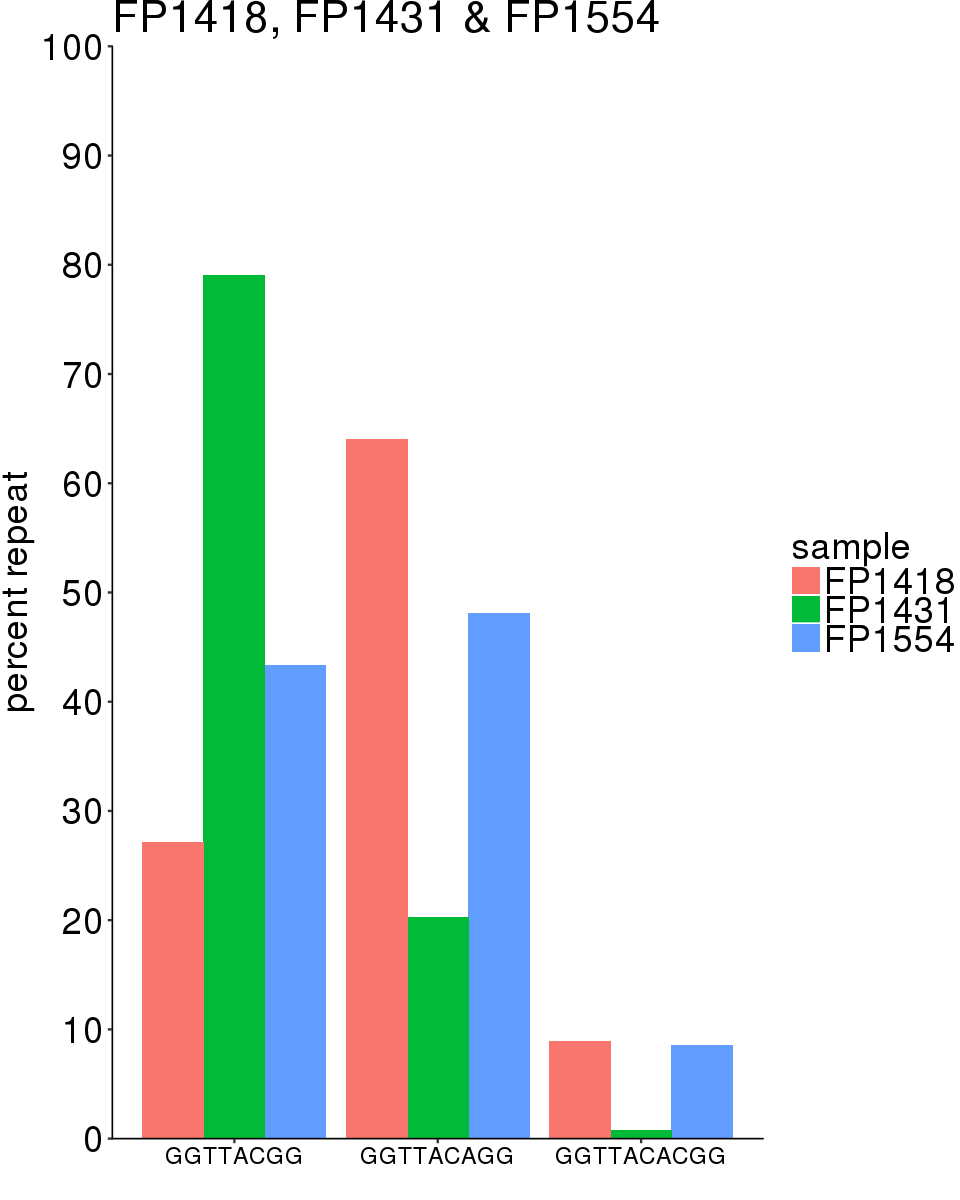

In [55]:

# specify order of motifs to display
df_all$motif <- factor(df_all$motif, 
                       levels = c('GGTTACGG', 'GGTTACAGG', 'GGTTACACGG'))

# plot dataframe
g <- ggplot(df_all, 
            aes(x    = motif, 
                y    = perc, 
                fill = sample)) + 
     geom_bar(stat = "identity", position = 'dodge') +
     scale_y_continuous(expand = c(0, 0), 
                        limits = c(0, 100), 
                        breaks = seq(0, 100, 10))+
        ylab("percent repeat") +xlab("") +
        ggtitle("FP1418, FP1431 & FP1554")

# customize plot theme
g1 <- g + theme(axis.text.x    = element_text(angle = 0, 
                                              vjust = 0.5, 
                                              size  = 14, 
                                              color = 'black'),
              axis.text.y      = element_text(size  = 22, 
                                              color = 'black'), 
              text             = element_text(size = 22),
              legend.text      = element_text(size = 22),
              panel.background = element_rect(fill = NA, colour = NA),
              plot.background  = element_rect(fill = NA, colour = NA),
              panel.border     = element_rect(fill = NA, color = NA), 
              axis.line.x      = element_line(colour = "black"),
              axis.line.y      = element_line(colour = "black"),
              axis.ticks       = element_line(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              strip.background = element_rect(colour = "black", fill = "black"),
              plot.margin      = unit(c(0, 0, 0, 0), "mm"),
              strip.text       = element_text(face = "bold"),
              legend.position  = 'right') 

g1

# save fig as pnd & pdf
#ggsave("./fig/wtvsmutant_motifcount.pdf", 
#       g1, height = 6, width = 8)
#ggsave("./fig/wtvsmutant_motifcount.png", 
#       g1, height = 6, width = 8)

## Repeat Motif Distribution Across Telomere Sequence

In [ ]:
# %load /home/msr/bin/reapeat_breaker_argparse.py
#!/home/msr/bin/anaconda/bin/python

"""This script is ran on the command line requiring an input fasta file, either 
(1) a file containg a list of repeats or (2) give the repeat as a string e.g. 'GGTTAC', and an output file
Example: reapeat_breaker_argparse.py -infile wildtype.fa -repeat_list repeat_list.txt -outfile wildtype_telos_by_rep.tsv

Note, if giving a list of repeats the order matters! if GGTTAC is first if finds all GGTTAC. if GGTTA is second it will not find any."""

import glob
import regex
import argparse
from Bio import SeqIO

######################## define arguments ########################################
parser = argparse.ArgumentParser(
    description='Count the number of repeat motifs and coordinates')

parser.add_argument('-infile', type=str, required=True,
                    help='input fasta file')

parser.add_argument('-repeat_list', type=str, required=False,
                    help='path to list of repeats file, one repeat per line')

parser.add_argument('-repeat', type=str, required=False,
                    help='specify repeat, example GGTTACAA')

parser.add_argument('-outfile', type=str, required=True,
                    help='path to output file')

args = parser.parse_args()
#########################################################################################

# if script given a list of repeats, then convert that txt file into an array
if args.repeat_list:
    with open(args.repeat_list, 'r') as f:
        repeats = [x.strip('\n') for x in f.readlines()] # converting txt file of repeats into usable array
elif args.repeat: # if script given single repeat
    repeats = [args.repeat]

print("searching for repeats: ", repeats)


def get_reps(fasta_file):
    """ this function takes a fasta file, loops through each sequence and 
    searches for the user supplied repeat(s). 
    
    stores the following information per sequence: 
    and indexing position, coordinates of repeat, repeat sequence, 
    sample name, fasta header, length of sequence
    
    writes results to tsv file."""
    
    samp_name = fasta_file.split(".")[0] # grab sample name from file name

    handle = open(fasta_file, "r")

    for record in SeqIO.parse(handle, "fasta"): # for each sequence
        seq = str(record.seq).upper() # convert to string and conver to uppercase
        seq_id = record.id    # store fasta header

        rep_list = [] # initialize array

        for i in repeats: # search for each repeat given
            match = regex.finditer(i, seq)
            if match: # for each match found
                for m in list(match):
                    s = m.start() # save start coord
                    e = m.end()   # save end coord
                    seq = seq.replace(seq[s:e], 'x' * (e - s)) # replace that repeat with an x, so that we do not count it again
                    rep_list.append(
                        [[s, e], i, samp_name, seq_id, len(seq)]) # store repeat and sequence info

        [rep_list.append([[m.start(), m.end()], m.group(), samp_name, seq_id, len(seq)])
         for m in list(regex.finditer('[^x+]', seq))] # this adds the coordinate information for each repeat found

        rep_list.sort(key=lambda x: x[0][0]) # sort by coordinate
    
        # write array to file
        with open(args.outfile, 'a') as fh_out:  # 'telos_by_rep_N.tsv'
            counter = 0 # this is an indexing number
            for entry in rep_list:
                fh_out.write(str(counter) + '\t' +  # save index
                             str(entry[0]) + '\t' + # save coordinate
                             entry[1] + '\t' +      # save repeat seq
                             entry[2] + '\t' +      # save sample name
                             entry[3] + '\t' +      # save fasta header
                             str(entry[4]) + '\n')  # save length of sequence
                counter += 1

    handle.close()


get_reps(args.infile)

'''
# testing

seq = "ggttacaggttacagggttagggtacagggttactgggtt"
seq = seq.upper()
print seq

test_dict = defaultdict(list)
print test_dict

final_list = []

for i in repeats:
    print i
    print seq
    match = regex.finditer(i, seq)
    if match:
        for m in list(match):
            s = m.start()
            e = m.end()
            test_dict[(s, e)] = i
            seq = seq.replace(i, 'x' * len(i))
            final_list.append([[s, e], i])
    print seq
print seq
[final_list.append([[m.start(), m.end()], m.group()])
 for m in list(regex.finditer('[^x+]', seq))]

final_list.sort(key=lambda x: x[0][0])
final_list
'''


In [ ]:
%%bash

reapeat_breaker_argparse.py -infile wildtype.fa -repeat_list wt_repeat_list.txt -outfile wt_telos_by_rep_GGTTAC.tsv

### Visualize repeats in sample

In [1]:
# start R kernel
library(ggplot2)
library(data.table)

In [ ]:
path <- "wildtype_telos_by_rep_GGTTAC.tsv"
df <- fread(path, sep='\t') # read in data
colnames(df) <- c('pos', 'choord', 'rep', 'sample', 'fasta_entry', 'seq_len') # name cols

seq_id_order <- unique(df[with(df, 
                               order(-seq_len, fasta_entry, pos)), ]$fasta_entry) # order by sequence length, longest to shortest

df$fasta_entry <- factor(df$fasta_entry, levels = rev(seq_id_order)) # apply above ordering to dataframe

max(df$seq_len) # check longest sequence

# separate the repeat entries from the nucleotide entries, this is required for plotting a shape vs a letter
df_sym <- subset(df, 
                 df$rep == 'GGTTACA[A,T][G,T]GTTACGTGGTTA[C,T]AC' |
                 df$rep == 'GGTTAC' | df$rep == 'GGTTACA') 
# order of repeats
df_sym$rep <- factor(df_sym$rep, levels = c('GGTTAC', 'GGTTACA',
                                            'GGTTACA[A,T][G,T]GTTACGTGGTTA[C,T]AC'))
# nuclotides between repeats
df_nts <- subset(df, df$rep == 'A' | df$rep == 'T' | 
                 df$rep == 'C' | df$rep == 'G')

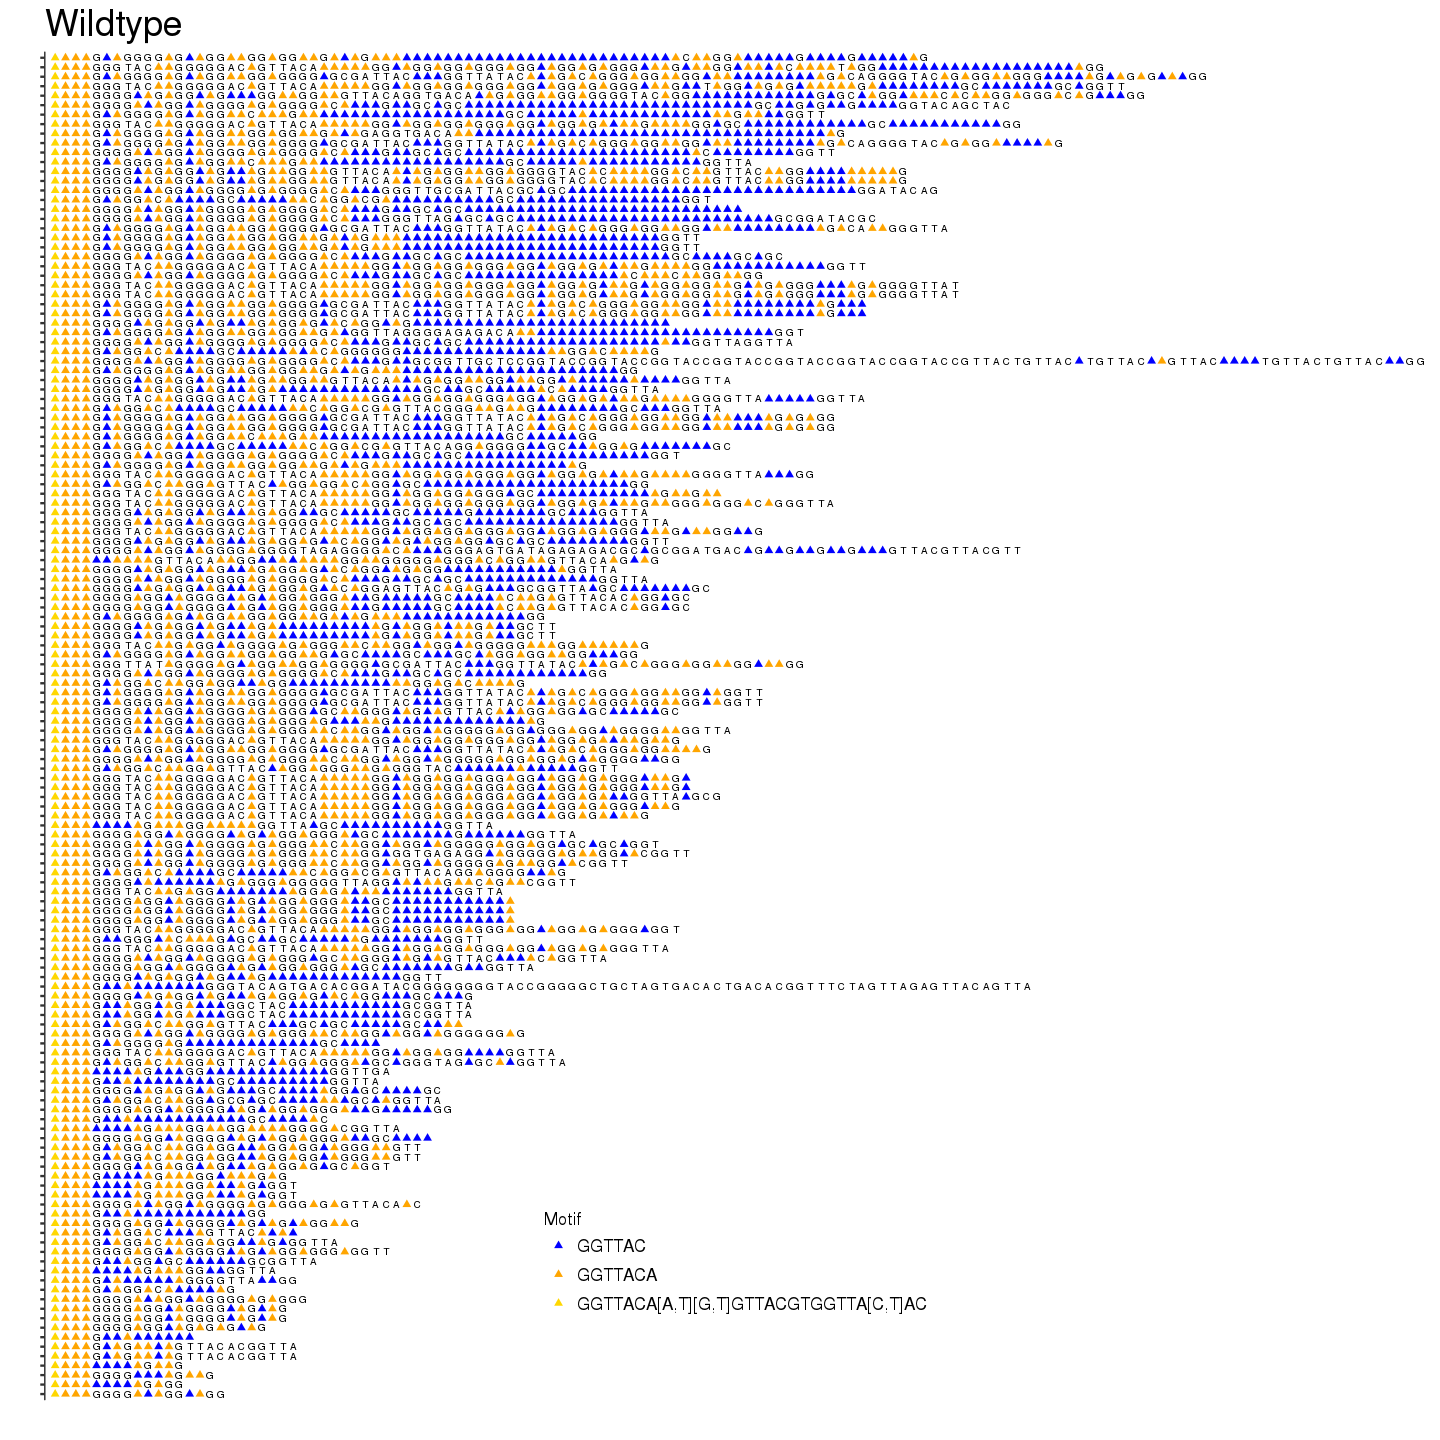

In [7]:
# set figure display dimensions
options(repr.plot.width=12, repr.plot.height=12)

g <- ggplot(data=NULL, 
            aes(x = pos, 
                y = fasta_entry)) +
            # plot the repeats as shapes
            geom_point(data = df_sym, 
                       aes(color = rep, 
                           shape = rep), 
                       size = 1.5) +
            # plot the nucleotides as letters
            geom_text(data = df_nts, 
                      aes(x = pos, 
                          y = fasta_entry, 
                          label = rep), 
                      size = 2) +
        
        theme_bw() +  
        # customize theme
        theme(legend.key  = element_blank(),
              axis.line.y = element_line(colour = "black", size = 0.25),
              axis.text.y = element_blank(),
              axis.line.x = element_line(colour = "black", size = 0.25),
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              panel.border = element_blank(),
              text = element_text(size = 18),
              legend.text = element_text(size = 10),
              legend.title = element_text(size = 10),
              legend.position = c(0.5, 0.1)) + 
        xlab("") + ylab("") +
        
        scale_x_continuous(expand = c(0, 1), 
                           limits = c(0, 132), 
                           breaks = NULL) + 
        
        scale_color_manual(name  = "Motif",
                          values = c('blue',
                                     'orange',
                                     'gold' # for cononical repeat
                                    )) +
        scale_shape_manual(name   = "Motif",
                           values = c(17, 17, 17)) + 
        ggtitle("Wildtype")

g
#ggsave("./figw/wt_telos_by_GGTTAC.png", 
#       g, height=10, width=10)
#ggsave("./fig/wt_telos_by_GGTTAC.pdf", 
#       g, height=10, width=10)

## Are overall differences in sequence lengths?

In [ ]:
# %load /home/msr/Projects/Maggie/GOCA/bin/count_seq_lengths.py
#!/home/msr/bin/anaconda/bin/python

"""This script is ran on the command line requiring an input direcotry of fasta files and an output file name.
Counts the length of each sequence in each fasta file in the given directory.
Example: count_seq_lengths.py -indir fasta_dir/ -outfile seq_lengths.tsv
"""

import glob
import argparse
import pandas as pd
from Bio import SeqIO
from collections import defaultdict

######################## define arguments ########################################
parser = argparse.ArgumentParser(
    description='Count length of each sequence in fasta file')
parser.add_argument('-indir', type=str, required=True,
                    help='input directory')
parser.add_argument('-outfile', type=str, required=True,
                    help='path to output file')

args = parser.parse_args()
###################################################################################

# key = (sample name, fasta header), value=length of sequence
seq_len_dict = defaultdict(list) # initialize dictionary as list


def get_seq_len(fasta_file):
    samp_name = fasta_file.split(".fa")[0] # grab sample name from file name
    
    handle = open(fasta_file, "r")

    for record in SeqIO.parse(handle, "fasta"):
        seq_len_dict[(samp_name, record.id)].append(len(record.seq)) # append seq length to dictionary

    handle.close()


[get_seq_len(name) for name in glob.glob(args.indir + "*")] # call function on each file in given dir

# write dict to tsv file
with open(args.outfile, 'a') as fh_out:
    for key, val in seq_len_dict.items():
        for x in val:
            fh_out.write(key[0] + '\t' + key[1] + '\t' + str(x) + '\n')


In [ ]:
%%bash

# example run
bin/count_seq_lengths.py -indir ./fasta_dir/ -outfile seq_lengths.tsv

### Plot sequence lengths per sample

In [ ]:
# start R kernel
library(ggplot2)
library(data.table)

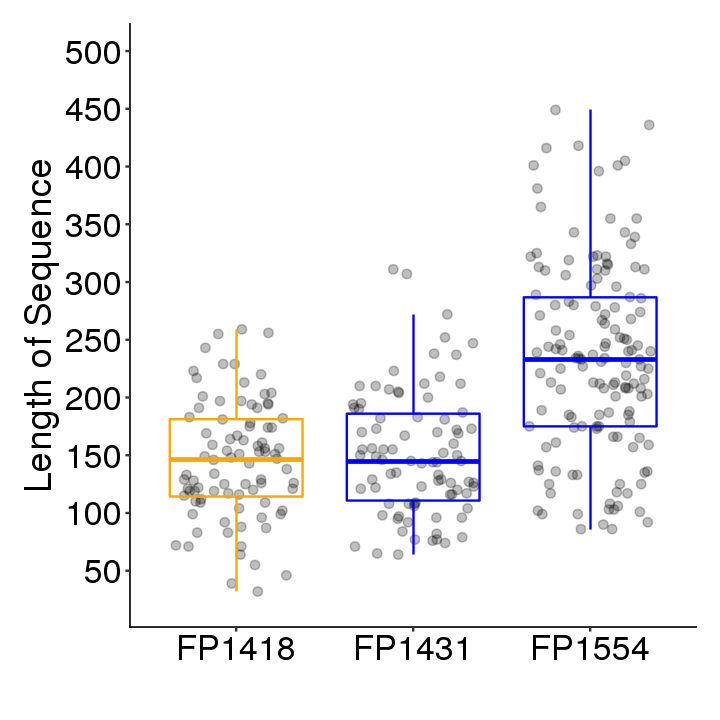

In [73]:
# fig display dim
options(repr.plot.width = 6, repr.plot.height = 6)

seq_lens <- fread("seq_lengths.tsv") # read in data
colnames(seq_lens) <- c('sample', 'fasta_header', 'len') # rename cols

# plot data as boxplot
gbox <- ggplot(seq_lens, 
               aes(x = sample, 
                   y = len)) + 

        # jitter data points behind boxplot
        geom_jitter(alpha = 0.25, 
                    size = 2, 
                    height = 0, 
                    width = 0.35) +
        
        geom_boxplot(outlier.shape=NA, fill = NA, 
                     colour = c('orange',
                                'blue', 
                                'blue')) + 
        
        scale_y_continuous(limits = c(25, 500),
                           breaks = seq(0, 1250, 50)) + 
        ylab("Length of Sequence") + xlab("")

# customize plotting theme
g1 <- gbox + theme(axis.text.x     = element_text(angle = 0, vjust = 0.5, 
                                                  size = 20, color = 'black'),
                   axis.text.y      = element_text(size = 20, color = 'black'), 
                   text             = element_text(size = 20),
                   legend.text      = element_text(size = 20),
                   panel.background = element_rect(fill = NA, colour = NA),
                   plot.background  = element_rect(fill = NA, colour = NA),
                   panel.border     = element_rect(fill = NA, color = NA), 
                   axis.line.x      = element_line(colour = "black"),
                   axis.line.y      = element_line(colour = "black"),
                   axis.ticks       = element_line(),
                   panel.grid.major = element_blank(),
                   panel.grid.minor = element_blank(),
                   strip.background = element_rect(colour = "black", fill = "black"),
                   plot.margin      = unit(c(5,5,5,5), "mm"),
                   strip.text       = element_text(face = "bold"),
                   legend.position  = 'bottom')

g1